# Analyse der Webanwendung "Spring PetClinic"  
   
   

## _Priorisierung von Umbauarbeiten nach Nutzungsgrad_


## Einlesen der Nutzungsstatistiken

In [16]:
import pandas as pd

coverage = pd.read_csv("../dataset/jacoco.csv")
coverage = coverage[
                ['PACKAGE',
                 'CLASS',
                 'LINE_COVERED',
                 'LINE_MISSED']]
coverage.head()

,PACKAGE,CLASS,LINE_COVERED,LINE_MISSED
0,org.springframework.samples.petclinic,PetclinicInitializer,24,0
1,org.springframework.samples.petclinic.model,NamedEntity,4,1
2,org.springframework.samples.petclinic.model,Specialty,1,0
3,org.springframework.samples.petclinic.model,PetType,1,0
4,org.springframework.samples.petclinic.model,Vets,0,4


### Berechnung Messwerte und Informationen

In [17]:
coverage['lines'] = coverage.LINE_COVERED + coverage.LINE_MISSED
coverage['ratio'] = coverage.LINE_COVERED / coverage.lines
coverage['fqn'] = coverage.PACKAGE + "." + coverage.CLASS
coverage[['fqn', 'ratio']].head()

,fqn,ratio
0,org.springframework.samples.petclinic.Petclini...,1.0
1,org.springframework.samples.petclinic.model.Na...,0.8
2,org.springframework.samples.petclinic.model.Sp...,1.0
3,org.springframework.samples.petclinic.model.Pe...,1.0
4,org.springframework.samples.petclinic.model.Vets,0.0


### Laden der Daten in die Graphdatenbank

In [18]:
import py2neo
graph = py2neo.Graph(password="password")
query="""
    UNWIND {coverage_data} as coverage
    MATCH (t:Type {fqn : coverage.fqn})
    MERGE (t)-[:HAS_MEASURE]->(m)
    SET 
        m:Measure:Coverage, 
        m.ratio = coverage.ratio
    RETURN t.fqn as fqn, m.ratio as ratio
"""
coverage_dict = coverage.to_dict(orient='records')
result = graph.run(query, coverage_data=coverage_dict).data()
pd.DataFrame(result).head()

,fqn,ratio
0,org.springframework.samples.petclinic.Petclini...,1.0
1,org.springframework.samples.petclinic.model.Na...,0.8
2,org.springframework.samples.petclinic.model.Sp...,1.0
3,org.springframework.samples.petclinic.model.Pe...,1.0
4,org.springframework.samples.petclinic.model.Vets,0.0


## Aggregation der Messwerte nach Subdomänen

In [19]:
query = """
MATCH 
  (t:Type)-[:BELONGS_TO]->(s:Subdomain),
  (t)-[:HAS_CHANGE]->(ch:Change),
  (t)-[:HAS_MEASURE]->(co:Coverage),
  (t)-[:DECLARES]->(m:Method)
OPTIONAL MATCH
  (t)-[:HAS_BUG]->(b:BugInstance)   
RETURN 
  s.name as ASubdomain,
  COUNT(DISTINCT t) as Types,
  COUNT(DISTINCT ch) as Changes,
  AVG(co.ratio) as Coverage,
  COUNT(DISTINCT b) as Bugs,
  SUM(DISTINCT m.lastLineNumber) as Lines
ORDER BY Coverage ASC, Bugs DESC
"""

In [20]:
result = pd.DataFrame(graph.data(query))
result

,ASubdomain,Bugs,Changes,Coverage,Lines,Types
0,Vet,0,75,0.155273,828,5
1,Visit,0,90,0.474944,1738,6
2,Owner,3,94,0.519492,2948,4
3,Pet,1,167,0.525654,3045,11
4,crossfunctional,2,53,0.625676,742,5
5,Clinic,0,26,0.888889,824,1
6,Person,0,5,1.000000,215,1
7,Specialty,0,4,1.000000,28,1


### Umbenennung nach geläufigen Begriffen

In [21]:
plot_data = result.copy()
plot_data = plot_data.rename(
    columns= {
        "Changes" : "Invest",
        "Coverage" : "Usage",
        "Lines" : "Size"})
plot_data

,ASubdomain,Bugs,Invest,Usage,Size,Types
0,Vet,0,75,0.155273,828,5
1,Visit,0,90,0.474944,1738,6
2,Owner,3,94,0.519492,2948,4
3,Pet,1,167,0.525654,3045,11
4,crossfunctional,2,53,0.625676,742,5
5,Clinic,0,26,0.888889,824,1
6,Person,0,5,1.000000,215,1
7,Specialty,0,4,1.000000,28,1


In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_portfolio_diagramm(plot_data, name):
      
    ax = plot_data.plot.scatter(
        "Invest",
        "Usage",
        s=plot_data.Size,
        alpha=0.7,
        title="Return on Invest ({})".format(name),
        figsize=[10,7],
        fontsize=14
    )

    ax.title.set_size(24)
    ax.title
    plt.xlabel('Invest', fontsize=18)
    plt.ylabel('Usage', fontsize=18)
    
    ax.plot(
        [plot_data.Invest.max()/2, plot_data.Invest.max()/2],
        [0, plot_data.Usage.max()], color='k', linestyle='--', linewidth=0.6)
    ax.plot(
        [0, plot_data.Invest.max()],
        [plot_data.Usage.max()/2,plot_data.Usage.max()/2], color='k', linestyle='--', linewidth=0.6)
    ax.text(plot_data.Invest.max()*1/4, plot_data.Usage.max()*3/4, "Success", ha="center", fontsize=24)
    ax.text(plot_data.Invest.max()*3/4, plot_data.Usage.max()*3/4, "Beware", ha="center", fontsize=24)
    ax.text(plot_data.Invest.max()*1/4, plot_data.Usage.max()*1/4, "Watch", ha="center", fontsize=24)
    ax.text(plot_data.Invest.max()*3/4, plot_data.Usage.max()*1/4, "Failure", ha="center", fontsize=24)

### Vier-Felder-Matrix zur Priorisierung nach Subdomänen

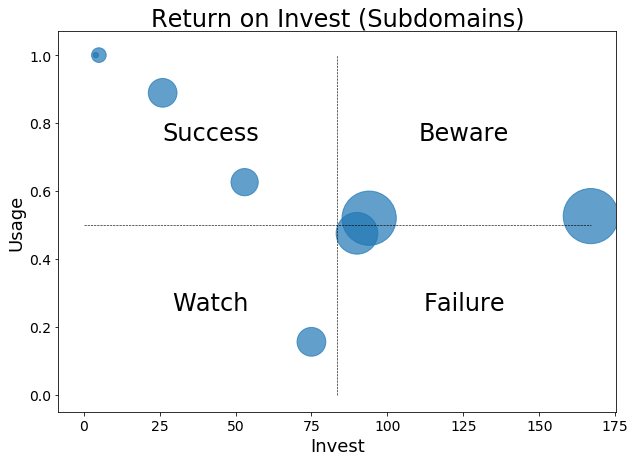

In [23]:
plot_portfolio_diagramm(plot_data, "Subdomains")

## Aggregation der Messwerte nach technischen Aspekten

In [24]:
query = """
MATCH 
  (t:Type)-[:IS_A]->(ta:TechnicalAspect),
  (t)-[:HAS_CHANGE]->(ch:Change),
  (t)-[:HAS_MEASURE]->(co:Coverage),
  (t)-[:DECLARES]->(m:Method)
OPTIONAL MATCH
  (t)-[:HAS_BUG]->(b:BugInstance)   
RETURN 
  ta.name as ATechnicalAspect,
  COUNT(DISTINCT t) as Types,
  COUNT(DISTINCT ch) as Invest,
  AVG(co.ratio) as Usage,
  COUNT(DISTINCT b) as Bugs,
  SUM(DISTINCT m.lastLineNumber) as Size
ORDER BY Usage ASC, Bugs DESC
"""

In [25]:
result = pd.DataFrame(graph.data(query))
result

,ATechnicalAspect,Bugs,Invest,Size,Types,Usage
0,jdbc,1,152,2093,8,0.000000
1,util,2,23,525,2,0.478947
2,web,2,156,2266,7,0.633593
3,model,1,91,3330,10,0.732048
4,jpa,0,54,580,4,0.741659
5,service,0,26,824,1,0.888889
6,petclinic,0,5,637,1,1.000000


### Vier-Felder-Matrix zur Priorisierung nach technischen Aspekten

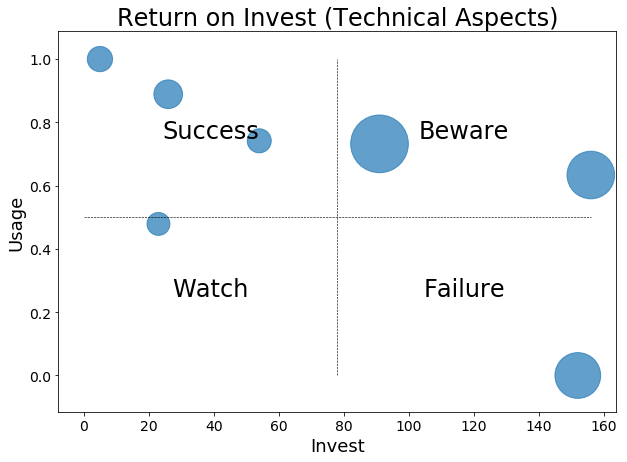

In [26]:
plot_portfolio_diagramm(result, "Technical Aspects")

# Ende Demo